In [2]:
its_jupyter_notebook = True

In [3]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from tqdm.notebook import tqdm
sys.path.insert(0, '..')


from util.evaluation import load_results, map_signal_to_sigmoid_range, balance_df
from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, get_results_based_on_treshold
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [4]:
checkpoint_dir_paths = []

chkpt_folder = os.path.join(ROOT_DIR, 'checkpoints')

models_to_check = os.listdir(chkpt_folder)
for model_name in models_to_check:
    model_folder = os.path.join(chkpt_folder, model_name)
    test_paris = os.path.join(chkpt_folder, model_name, 'test_results500.csv')
    ricseq = os.path.join(chkpt_folder, model_name, 'ricseq_results500.csv')
    splash = os.path.join(chkpt_folder, model_name, 'splash_results500.csv')
    
    testENHN_paris = os.path.join(chkpt_folder, model_name, 'testENHN_results500.csv')
    ricseqENHN = os.path.join(chkpt_folder, model_name, 'ricseqENHN_results500.csv')
    splashENHN = os.path.join(chkpt_folder, model_name, 'splashENHN_results500.csv')
    if os.path.exists(test_paris) & os.path.exists(ricseq) & os.path.exists(splash) & os.path.exists(testENHN_paris) & os.path.exists(ricseqENHN) & os.path.exists(splashENHN) :
        checkpoint_dir_paths.append(model_folder)

In [5]:
space = 'linear'
n_values = 12
MIN_PERC = 1

assert space in ['log', 'linear']

In [6]:
# for i in range(1, 1_000):
#     df_full, name_map, confidence_level = load_results(checkpoint_dir_paths[:i], space, n_values, MIN_PERC, chkpt_folder)

In [7]:
df_full, name_map, confidence_level = load_results(checkpoint_dir_paths[:1], space, n_values, MIN_PERC, chkpt_folder)

#df = otain_results(checkpoint_dir_paths[:3], space, n_values, MIN_PERC)

In [8]:
df_full = df_full.groupby('model').mean().reset_index()

# Curve

In [120]:
n_best = 5
min_auc_on_all_dataset = 0.53
way = 0

In [121]:
plt.rcParams['figure.figsize'] = [10, 7]

In [122]:
df_auc = df_full.filter(['model', 
                         'paris_auc_interactors',  'ricseq_auc_interactors', 'splash_auc_interactors', 'splashtest_auc_interactors',
                        'paris_auc_patches',  'ricseq_auc_patches', 'splash_auc_patches', 'splashtest_auc_patches'])
df_tnr = df_full[['model', 'TNR_HN_paris_difficult', 'TNR_EN_paris_difficult', 
                  'TNR_HN_ricseq_difficult', 'TNR_EN_ricseq_difficult',
                  'TNR_HN_splash_test_difficult', 'TNR_EN_splash_test_difficult']]

###### Add manually INTARNA values to the dataframe
intarna_values = [68.95, 70.21, 68.06, 70.15, 69.3, 67.91]
df_tnr.loc[df_tnr['model'] == 'INTARNA', ['TNR_HN_paris_difficult', 'TNR_EN_paris_difficult',
                                  'TNR_HN_ricseq_difficult', 'TNR_EN_ricseq_difficult',
                                  'TNR_HN_splash_test_difficult', 'TNR_EN_splash_test_difficult']] = intarna_values

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


In [123]:
df_tnr['mean_TNR'] = df_tnr.filter(['TNR_HN_paris_difficult', 'TNR_EN_paris_difficult',
       'TNR_HN_ricseq_difficult', 'TNR_EN_ricseq_difficult',
       'TNR_HN_splash_test_difficult', 'TNR_EN_splash_test_difficult']).mean(axis = 1)

mean_tnr_intarna = df_tnr[df_tnr.model == 'INTARNA'].mean_TNR.iloc[0]
better_than_intarna = df_tnr[df_tnr.mean_TNR>mean_tnr_intarna].model


mean_tnr_intarna_ensplash = df_tnr[df_tnr.model == 'INTARNA'].TNR_EN_splash_test_difficult.iloc[0]
better_than_intarna_ensplash = df_tnr[df_tnr.TNR_EN_splash_test_difficult>mean_tnr_intarna_ensplash].model

/tmp/ipykernel_3317620/502714800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tnr['mean_TNR'] = df_tnr.filter(['TNR_HN_paris_difficult', 'TNR_EN_paris_difficult',


In [124]:
if way == 0:
    #take the best models I ve chosen
    best_models = set(['model150', 'model115', 'model203', 'model87', 'model90', 'model207']).union(set(['INTARNA']))
elif way == 1:
    #way1
    df_select = df_auc[(df_auc.drop('model', axis = 1) > min_auc_on_all_dataset * 100).all(axis = 1)]
    best_models = set(df_select.sort_values('mean', ascending = False).head(n_best)['model']).union(set(['INTARNA']))
elif way == 2:
    #way2
    best_paris = set(df_select.sort_values('paris_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_ricseq = set(df_select.sort_values('ricseq_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_splash = set(df_select.sort_values('splash_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_models = ( best_paris.intersection(best_ricseq).intersection(best_splash) ).union(set(['INTARNA']))
elif way == 3:
    #take the best in ricseq
    best_models = set(df_auc.sort_values('ricseq_auc_interactors', ascending = False).head(n_best)['model']).union(set(['INTARNA']))

elif way == 4:
    #take the best in ricseq and better than intarna in TNR 500
    best_models = set(df_auc[df_auc.model.isin(better_than_intarna)].sort_values('ricseq_auc_interactors', ascending = False).head(n_best)['model']).union(set(['INTARNA']))
elif way == 5:
    #take the best in ricseq and better than intarna in TNR 500 (TNR 500 only in splash)
    best_models = set(df_auc[df_auc.model.isin(better_than_intarna_ensplash)].sort_values('ricseq_auc_interactors', ascending = False).head(n_best)['model']).union(set(['INTARNA']))
    
elif way == 6:
    #ricseq highest peak
    ricseq_columns_conf = [i for i in df_full.columns if 'ricseqtest_interactors_f1_conf' in i]
    df_full['ricseq_highest_peak'] = df_full.filter(ricseq_columns_conf, axis = 1).max(axis = 1)
    best_models =  set(df_full.sort_values('ricseq_highest_peak', ascending = False).head(n_best)['model']).union(set(['INTARNA']))
    
elif way == 7:
    #ricseq highest peak and better than intarna in TNR 500
    ricseq_columns_conf = [i for i in df_full.columns if 'ricseqtest_interactors_f1_conf' in i]
    df_full['ricseq_highest_peak'] = df_full.filter(ricseq_columns_conf, axis = 1).max(axis = 1)
    best_models =  set(df_full[df_full.model.isin(better_than_intarna)].sort_values('ricseq_highest_peak', ascending = False).head(n_best)['model']).union(set(['INTARNA']))


In [125]:
def obtain_df_curve(task_name, metric, model_list, best_models, confidence_level, df_full):

    diz_curve = {}

    for set_name in model_list:
        diz_dataset = {}
        for model in best_models:
            datasetlist = []
            for conf in confidence_level:
                modelrow = df_full[df_full['model'] == model]

                value = modelrow[f'{set_name}_{task_name}_{metric}_conf{conf}'].iloc[0]

                datasetlist.append(value)  
            diz_dataset[model] = datasetlist
        diz_curve[set_name] = diz_dataset

    df_curve = pd.DataFrame.from_dict(diz_curve, 'index')#.reset_index().rename({'index':'dataset'}, axis = 1)
    return df_curve

In [126]:
task_name = 'patches'
metric = 'precision_recall_curve' #precision_recall_curve, f1
model_list = ['splashtest', 'splash', 'ricseq', 'paris']

In [127]:
# best_models = best_models.union(['model80', 'model98', 'INTARNA',
#                                  'model101', 'model102', 'model103', 
#                                  'model104', 'model105', 'model106', 
#                                  'model107', 'model108'])
#best_models = set(['model80', 'model98', 'INTARNA']).union([f'model{i}' for i in range(101, 117)])

In [128]:
df_curve = obtain_df_curve(task_name, metric, model_list, best_models, confidence_level, df_full)

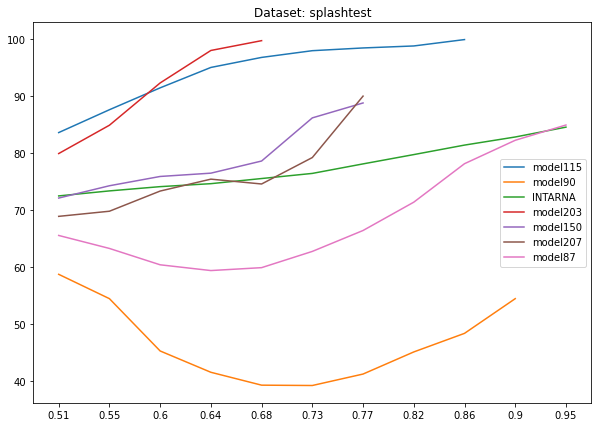

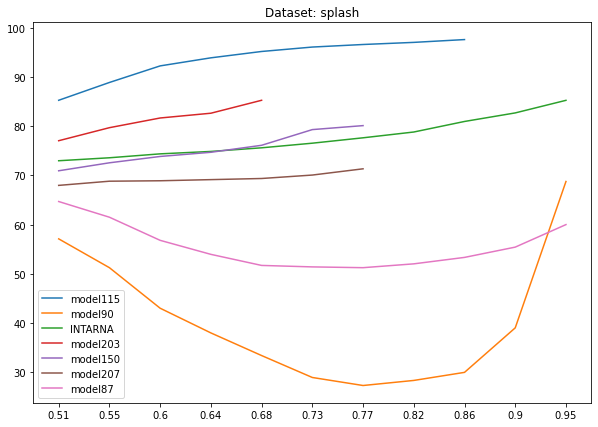

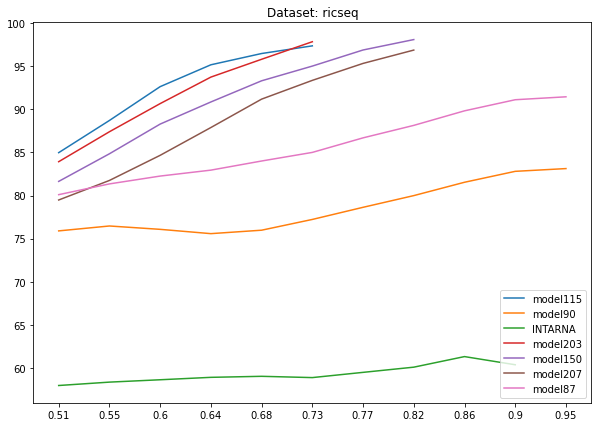

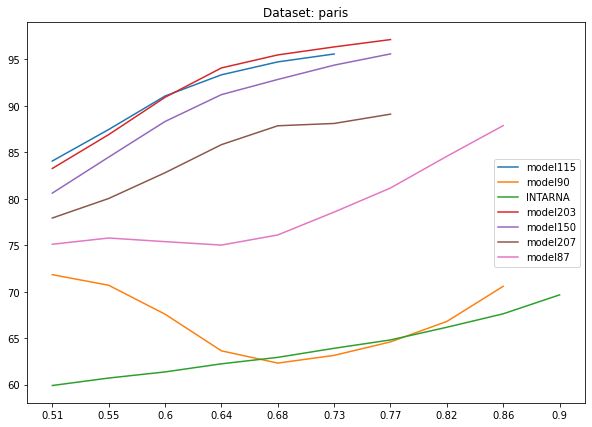

In [129]:
for dataset in model_list:
    row = df_curve.loc[dataset]
    for model in best_models:
        plt.plot(confidence_level, row[model], label = model)
      
    plt.title(f'Dataset: {dataset}')
    plt.legend()
    plt.show()

In [130]:
task_name = 'interactors'
df_curve = obtain_df_curve(task_name, metric, model_list, best_models, confidence_level, df_full)

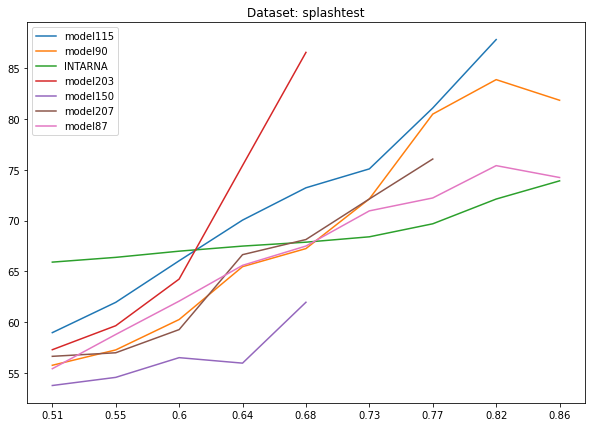

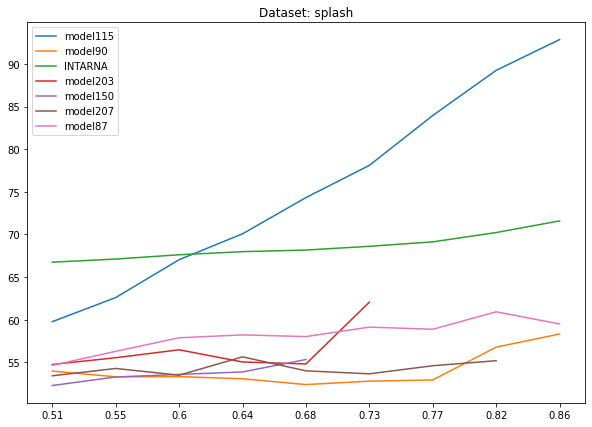

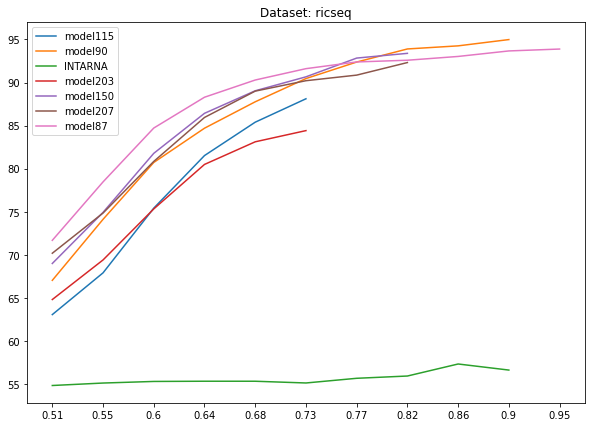

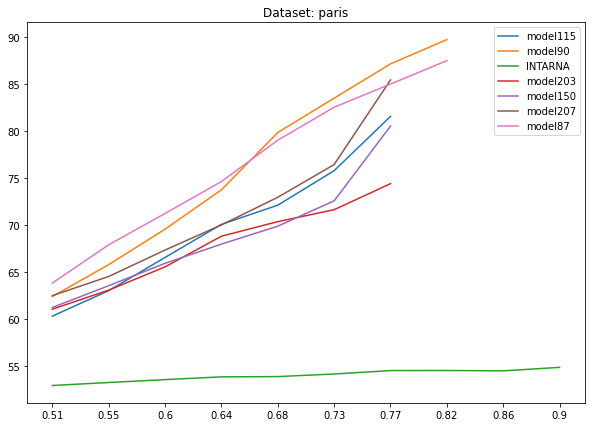

In [131]:
for dataset in model_list:
    row = df_curve.loc[dataset]
    for model in best_models:
        plt.plot(confidence_level, row[model], label = model)
      
    plt.title(f'Dataset: {dataset}')
    plt.legend()
    plt.show()

In [132]:
df_tnr = df_tnr[df_tnr.model.isin(best_models)]

diz_name = {}
for i in df_tnr.columns:
    diz_name[i] = i.replace("_difficult", "")
    
df_tnr = df_tnr.rename(diz_name, axis = 1)

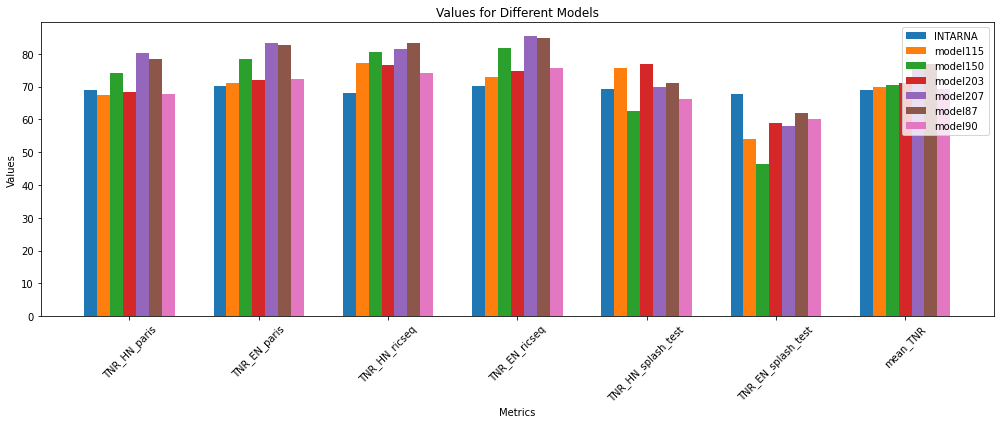

In [133]:
# Plotting
models = df_tnr['model'].tolist()
columns = df_tnr.columns[1:]

x = np.arange(len(columns))

plt.figure(figsize=(14, 6))
bar_width = 0.1

for i, model in enumerate(models):
    plt.bar(x + i * bar_width, df_tnr.loc[df_tnr['model'] == model, columns].values.flatten(),
            width=bar_width, label=model)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Values for Different Models')
plt.xticks(x + bar_width * (len(models) - 1) / 2, columns, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [134]:
for i in list(best_models):
    if i != 'INTARNA':
        print(i, name_map[i])

model115 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083
model90 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0059
model203 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0060
model150 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039_NOWENHNokSN_PARISFINETUNINGtrainhqSPLASHval0043
model207 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfine

### GOOD MODELS
- 115:
all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083
- 203:
all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0060
- 150:
all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039_NOWENHNokSN_PARISFINETUNINGtrainhqSPLASHval0043
- 87:
all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055
- 90:
all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0059
- 207:
all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0079

In [36]:
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28_splash103
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_easypretrain10_paristfinetuningSPLASHval29_ricseqSPLASHval60_splashRICSEQval110
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28_splashBEST
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151

In [37]:
columns_to_print = ['model', 
                    'paris_auc_ES', 'paris_auc_EPENHN',
                    'ricseq_auc_ES', 'ricseq_auc_EPENHN',
                    'splash_auc_ES', 'splash_auc_EPENHN']
df_full[df_full['model'].isin(models_selected)|(df_full['model']=='INTARNA')].filter(columns_to_print, axis = 1).round(2)

NameError: name 'models_selected' is not defined

In [ ]:
models_selected = ['model7', 'model9', 'model10', 'model12', 'model15', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26']

In [ ]:
columns_to_print = ['model', 
                    'paris_auc_ES', 'paris_auc_EPENHN',
                    'ricseq_auc_ES', 'ricseq_acc_ES_notrain', 'ricseq_auc_EPENHN',
                    'splash_auc_ES', 'splash_auc_EPENHN']
df_full[df_full['model'].isin(models_selected)|(df_full['model']=='INTARNA')].filter(columns_to_print, axis = 1).round(2)

### Correlation between ricsecTest VS ricseq, splashTest VS splash

Sembra esserci una correlazione abbastanza forte, quindi posso utilizzare i dati di test per fare tutte le altre analisi.

In [ ]:
only_test = False
df_full_F, name_map_F, confidence_level = otain_results(checkpoint_dir_paths, space, n_values, MIN_PERC, only_test)

In [ ]:
ok_ricseq = [ os.path.join(chkpt_folder, i) for i in [
    'all_modelarch2_easypretrain3_paristfinetuningSPLASHval8', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval30',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval20',
             'all_modelarch1_easypretrain7_paristrain22', 
             'all_modelarch1_easypretrain7_paristrain12_trainhq',
             'all_modelarch2_easypretrain3_paristfinetuning13',
             'all_modelarch2_easypretrain3_paristfinetuning14', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval12'
]]



ok_splash = [os.path.join(chkpt_folder, i) for i in [
    'all_modelarch2_easypretrain3_paristfinetuningSPLASHval8', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval30',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval20',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18_ricseqSPLASHvalBEST',
             'all_modelarch1_easypretrain7_paristrain22',
             'all_modelarch1_easypretrain7_paristrain12_trainhq',
             'all_modelarch2_easypretrain3_paristfinetuning13',
             'all_modelarch2_easypretrain3_paristfinetuning14',
             'all_modelarch2_easypretrain3_paristfinetuning14_ricseq20',
             'all_modelarch2_easypretrain3_paristfinetuning14_ricseq23',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18',
             'all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval12',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18_ricseqSPLASHval20',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29_ricseqSPLASHvalBEST'
]]

In [ ]:
map_splash = {}
for i in ok_splash:
    for j in name_map.keys():
        if name_map[j] == i:
            name_map_splash = j
    for j in name_map_F.keys():
        if name_map[j] == i:
            name_map_splash_F = j
    map_splash[name_map_splash] = name_map_splash_F

map_splash = pd.DataFrame.from_dict(map_splash, 'index').reset_index().rename({'index':'name_map', 0:'name_map_F'}, axis = 1)
    
map_ricseq = {}
for i in ok_ricseq:
    for j in name_map.keys():
        if name_map[j] == i:
            name_map_ricseq = j
    for j in name_map_F.keys():
        if name_map[j] == i:
            name_map_ricseq_F = j
    map_ricseq[name_map_ricseq] = name_map_ricseq_F
    
map_ricseq = pd.DataFrame.from_dict(map_ricseq, 'index').reset_index().rename({'index':'name_map', 0:'name_map_F'}, axis = 1)


In [121]:
#assert we dont have to change names of the dataframes, otherwise we have to modify the names, I didnt implement this case
if ((map_ricseq.name_map == map_ricseq.name_map_F).all()) & ((map_splash.name_map == map_splash.name_map_F).all()):
    pass
else:
    raise NotImplementedError

In [122]:
df_ricseq = df_full[df_full['model'].isin(set(map_ricseq['name_map']))][['model', 'ricseq_auc_ES']]
df_ricseq_F = df_full_F[df_full_F['model'].isin(set(map_ricseq['name_map']))][['model', 'ricseq_auc_ES']]

df_splash = df_full[df_full['model'].isin(set(map_splash['name_map']))][['model', 'splash_auc_ES']]
df_splash_F = df_full_F[df_full_F['model'].isin(set(map_splash['name_map']))][['model', 'splash_auc_ES']]

In [123]:
df_ricseq = df_ricseq.merge(df_ricseq_F, on = 'model').drop('model', axis = 1).rename(
    {'ricseq_auc_ES_x':'ricseq_auc_ES_Test', 
    'ricseq_auc_ES_y':'ricseq_auc_ES_Full'}, axis = 1)

df_splash = df_splash.merge(df_splash_F, on = 'model').drop('model', axis = 1).rename(
    {'splash_auc_ES_x':'splash_auc_ES_Test', 
    'splash_auc_ES_y':'splash_auc_ES_Full'}, axis = 1)

Correlation Matrix:
                    ricseq_auc_ES_Test  ricseq_auc_ES_Full
ricseq_auc_ES_Test            1.000000            0.986051
ricseq_auc_ES_Full            0.986051            1.000000


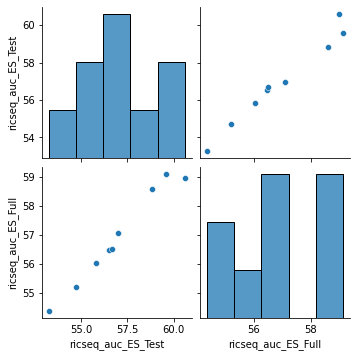

In [124]:
plot_correlation(df_ricseq)

Correlation Matrix:
                    splash_auc_ES_Test  splash_auc_ES_Full
splash_auc_ES_Test            1.000000            0.762477
splash_auc_ES_Full            0.762477            1.000000


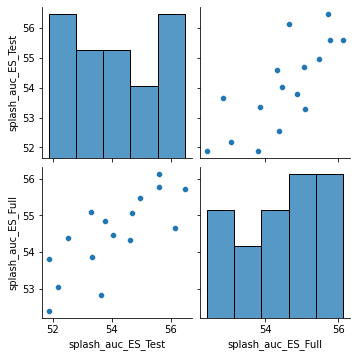

In [125]:
plot_correlation(df_splash)